
# Data Analysis Project: European Soccer Project 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

<a id='intro'></a>
## Introduction

European Soccer dataset contains data of matches, teams and players from soccer leagues in Europe for the time period, 2008 to 2016. I have chosen to focus first on one club, Liverpool Football Club (LFC) which plays in the English Premier League and I am also curious about the performance characteristics of all the players in the database. 

In [46]:
# import statements 
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_absolute_percentage_error, r2_score


<a id='wrangling'></a>
## Data Wrangling

Connecting with SQLite database and reading the SQL tables into Pandas Dataframes.

In [14]:

# Load data from SQLite database onto Pandas dataframes

#open a connection with the SQLite database
sqll_connect = sqlite3.connect('database.sqlite')
#sqll_cursor = sqll_connect.cursor()

#read the SQL tables and load them into Pandas dataframes
match = pd.read_sql_query("SELECT * FROM Match", sqll_connect)
team = pd.read_sql_query("SELECT * FROM Team", sqll_connect)
team_att = pd.read_sql_query("SELECT * FROM Team_Attributes", sqll_connect)
#league = pd.read_sql_query("SELECT * FROM League", sqll_connect)
player = pd.read_sql_query("SELECT * FROM player", sqll_connect)
player_att = pd.read_sql_query("SELECT * FROM Player_Attributes", sqll_connect)

In [6]:
#explore the dfs
team.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [7]:
#explore the dfs
league.head(2)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League


In [8]:
match.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


In [52]:
match.shape

(25979, 115)

In [16]:
#data check
#pd.set_option('display.max_rows', None)  # or 1000
#match.isnull().sum()
#match.isna().sum()

In [14]:
match.duplicated().sum()

0

In [62]:
#create a new dataframe with only data from English premier league
epl_matches = match[match['league_id'] == 1729]
epl_matches.shape

(3040, 115)

In [63]:
#explore the columns of the new dataframe
epl_matches.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [65]:
#drop columns that will not be used in project
''' Columns dropped:
1) Columns with the position of each player;(x,y) coordinates
2) XML data on fouls, cards, crosses, corners, possession
3) Columns with betting odds from different sports betting platforms llike bet365.com
4) Country id and league id are redundant data'''

# 1) drop columns (index 11 to 54) with data on the position of each player;(x,y) coordinates
epl_matches.drop(epl_matches.columns[11:55], axis = 1, inplace = True)

In [66]:
# 2) drop data on betting odds for the game from different betting platforms
epl_matches.drop(epl_matches.loc[:,'B365H':].columns, axis = 1, inplace = True)

In [67]:
# 3) xml data provided are not relevant to the analysis and hence dropped
epl_matches.drop(epl_matches.loc[:,'goal':].columns, axis = 1, inplace = True)

In [68]:
# 4) dropping country and league columns since EPL is limited to United Kingdom
epl_matches.drop(['country_id','league_id'], axis = 1, inplace = True) 

In [69]:
epl_matches.shape

(3040, 31)

In [1]:
#checking for missing values in columns
#epl_matches.info() 

In [72]:
#create a new dataframe with only Liverpool club's data
lfc_matches = epl_matches.query('home_team_api_id == 8650 or away_team_api_id == 8650')

<a id='eda'></a>
## Exploratory Data Analysis 

I would like to analyse the performance of Liverpool each season against other teams. 

The match dataframe contains information of only the goals scored in each match and does not indicate which team won nor the points scored by each team. Hence this information is needed to be derived from the available data to answer below exploratory questions.

#### Setting the Baseline : 
<b> 
What was Liverpool's performance each season?  
</b>

#### Scoring System :
In the English Premier League, each team gets 3 points for winning a game, 1 point for a tie and 0 points for loss. The points are then totaled at the season to determine the winner of the league for that season. 

The data available only has information of the goals scored by each team in each match. The result of each game and the points scored by each team has to be derived from the available data. 

In [ ]:
# Derive the result of each game for the home team from the goals scored as win, loss or tie.
epl_matches['home_team_result'] = np.where(epl_matches.home_team_goal == epl_matches.away_team_goal, 'tie',    
                                     np.where(epl_matches.home_team_goal > epl_matches.away_team_goal,'win', 'loss'))

# Derive the points achieved by the home team based on the results
epl_matches['home_team_points'] = np.where(epl_matches.home_team_result == 'win', 3,
                                          np.where(epl_matches.home_team_result == 'tie', 1, 0))

# merge with team dataframe to add the team name and remove/rename columns as needed
epl_matches = epl_matches.merge(team[['team_api_id','team_long_name']],left_on='home_team_api_id',right_on='team_api_id')
epl_matches.drop(['team_api_id'], axis = 1, inplace = True)
epl_matches.rename(columns={"team_long_name":"home_team_name"}, inplace=True)

In [74]:
# Derive the result of each game for the away team from the goals scored as win, loss or tie.
epl_matches['away_team_result'] = np.where(epl_matches.away_team_goal == epl_matches.home_team_goal, 'tie',    
                                     np.where(epl_matches.away_team_goal > epl_matches.home_team_goal,'win', 'loss'))

epl_matches['away_team_points'] = np.where(epl_matches.away_team_result == 'win', 3,
                                          np.where(epl_matches.away_team_result == 'tie', 1, 0))

epl_matches = epl_matches.merge(team[['team_api_id','team_long_name']],left_on='away_team_api_id',right_on='team_api_id')
epl_matches.drop(['team_api_id'], axis = 1, inplace = True)
epl_matches.rename(columns={"team_long_name":"away_team_name"}, inplace=True)

#### Liverpool Football Club Data

In [80]:
# classify each match as tie, win or loss for LFC
# logic used is to first check if the match was a tie and if not identify the wins by checking if Liverpool won as home team or away team and if not mark as loss since it is the only other possible result
# why np.where? reference: https://stackoverflow.com/questions/27041724/using-conditional-to-generate-new-column-in-pandas-dataframe
lfc_matches['result'] = np.where(lfc_matches.home_team_goal == lfc_matches.away_team_goal, 'tie',    
                                     np.where((lfc_matches.home_team_api_id == 8650) & (lfc_matches.home_team_goal > lfc_matches.away_team_goal),'win', 
                                              np.where((lfc_matches.away_team_api_id == 8650) & (lfc_matches.away_team_goal > lfc_matches.home_team_goal),'win','loss'))) 

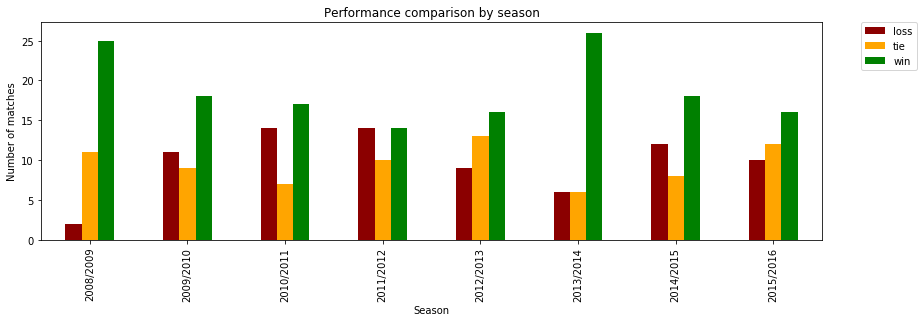

In [83]:
#plot results grouped by season
lfc_matches.groupby(['season','result'])['season'].count().unstack('result').plot(kind='bar',figsize=(14,4), color = ['darkred','orange','green'])
plt.title('Performance comparison by season')
plt.xlabel('Season')
plt.ylabel('Number of matches')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

In [84]:
# tabulate the results to view the results in different formats for exploration
lfc_matches.groupby(['season'])['result'].value_counts().unstack().transpose()

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
result,,,,,,,,
loss,2,11,14,14,9,6,12,10
tie,11,9,7,10,13,6,8,12
win,25,18,17,14,16,26,18,16
